### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Для того, чтобы выбрать тот или иной набор акционных предложений необходимо проверить являются ли полученные различия между группами статистически значимы. 
а. Так, первым шагом проанализируем Convertion Rate (CR) в покупку. Действительно ли доля клиентов в контрольной группе выше чем в тестовой?
б. Далее, проверим статистически ли значимо различается средний чек на пользователя двух групп.

*user_id* - id пользователя

*revenue* - доход с пользователя

*testgroup* - метки [a, b] для контральной и тестовой групп 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.proportion import proportions_ztest
from tqdm.auto import tqdm
import statsmodels.api as sm

%matplotlib inline

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [3]:
data = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep=';')
data.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
a = "***___***"
print(a*5+'\n')
print(data.info())
print(a*5+'\n')
print('Доля пользователей каждой группы')
print(data['testgroup'].value_counts(normalize=True))
print(a*5+'\n')
print('Присутсвует ли один и тот же пользователь сразу в двух группах?')
print(data['user_id'].duplicated().value_counts())

***___******___******___******___******___***

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB
None
***___******___******___******___******___***

Доля пользователей каждой группы
b    0.500697
a    0.499303
Name: testgroup, dtype: float64
***___******___******___******___******___***

Присутсвует ли один и тот же пользователь сразу в двух группах?
False    404770
Name: user_id, dtype: int64


In [21]:
#т.к. в каждой из групп находятся только уникальные пользователи можем использовать тесты для независимых выборок

In [5]:
#Для целей дальнейших исследований добавим в наш датасет колонку 'purchase',
#в которой будет записан 0 для пользователей которые не совершали целевого действия ( т.е. их 'revenue' == 0)
#и 1 для платящих пользователей
data['purchase'] = [0 if x==0 else 1 for x in data['revenue']]

#Проверим, правильность  заполнения поля 'purchase'
print(data.query('revenue == 0')['revenue'].count() == data.query('purchase == 0')['purchase'].count())
print(data.query('revenue != 0')['revenue'].count() == data.query('purchase != 0')['purchase'].count())

True
True


In [6]:
data_prop = data.groupby(['testgroup', 'purchase'], as_index=False).agg({'revenue':'count'})\
              .pivot(index='testgroup', columns='purchase', values='revenue')
data_prop['CR'] = round(data_prop[1]/(data_prop[0]+data_prop[1])*100, 2)
data_prop

purchase,0,1,CR
testgroup,,,
a,200175,1928,0.95
b,200862,1805,0.89


Тест 1: Статистически ли значимо различаются доли людей совершивших целевое действие (покупку) в контрольной и тестовой группах?

Для проверки воспользуемся z-критерием 

In [7]:
#Интервальная оценка долей
conf_interval_a = proportion_confint(sum(data.query('testgroup == "a"')['purchase']),
                                     data.query('testgroup == "a"')['purchase'].count(), 
                                     method='normal')
conf_interval_b = proportion_confint(sum(data.query('testgroup == "b"')['purchase']),
                                     data.query('testgroup == "b"')['purchase'].count(), 
                                     method='normal')

print("Confidence interval for group a:{}".format(conf_interval_a))
print("Confidence interval for group b:{}".format(conf_interval_b))

Confidence interval for group a:(0.009115903398184955, 0.009963476917792542)
Confidence interval for group b:(0.00849719982771449, 0.009315270875458697)


In [26]:
#Интервальная оценка не дала однозначного ответа какая акция показала лучший результат, т.к. 95% доверительные интервалы двух групп пересекаются

In [8]:
#z-test на равенство пропорций 2-ух групп
#H0: proportion_a = proportion_b
#H1: proportion_a != proportion_b
sample_a_success = data.query('testgroup == "a"')['purchase'].sum()
sample_b_success = data.query('testgroup == "b"')['purchase'].sum()
sample_a_size = data.query('testgroup == "a"')['purchase'].count()
sample_b_size = data.query('testgroup == "b"')['purchase'].count()

stat, p_value = proportions_ztest(count=[sample_a_success, sample_b_success], nobs=[sample_a_size, sample_b_size], alternative='two-sided')
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

z_stat: 2.108, p_value: 0.035


Результат теста P-value < 0.05. Результат стастически значим, исходя из чего нулевая гипотеза о равенстве пропорций отвергается

In [9]:
#z-test на равенство пропорций 2-ух групп
#From proportions_ztest discription: In the two sample test, smaller means that the alternative hypothesis is ``p1 < p2`` and
    #larger means ``p1 > p2`` where ``p1`` is the proportion of the first
    #sample and ``p2`` of the second one.
#H0: proportion_a !> proportion_b
#H1: proportion_a > proportion_b
sample_a_success = data.query('testgroup == "a"')['purchase'].sum()
sample_b_success = data.query('testgroup == "b"')['purchase'].sum()
sample_a_size = data.query('testgroup == "a"')['purchase'].count()
sample_b_size = data.query('testgroup == "b"')['purchase'].count()

stat, p_value = proportions_ztest(count=[sample_a_success, sample_b_success], nobs=[sample_a_size, sample_b_size], alternative='larger')
print('z_stat: %0.3f, p_value: %0.3f' % (stat, p_value))

z_stat: 2.108, p_value: 0.018


Результат одностороннего z-test показал статистически значимый p-value < 0.05, следовательно гипотеза о том, что зачение пропорции группы 'а' не больше группы 'b' отвергается. Альтернативная гипотеза не отвергается, исходя из чего можно сделать вывод о том, что в группе 'а' (контроль) пропорция пользователей совершивших покупку статистически значимо больше. 
(0.95% - 0.89%)/0.89% = 0.067% Коэффициент конверсии в покупку в группе 'а'  на 0.067% выше, чем коэффициент конверсии в группе 'b'. Этот результат — следствие более привлекательного для пользователей предложения, а не случайность. Уровень доверия 95%.

При этом известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. Можно сделать предположение о том, что несмотря на то, что конверсия в клиента в контрольной группе выше, в тестовой группе клиенты потенциально тратят больше. 

Тест 2: Статистически ли значимы различия между средним чеком пользователей (ARPU) в контрольной и тестовой групп?

In [10]:
a = data.groupby('testgroup', as_index=False).agg({'revenue':'sum', 'purchase':'count'})
a['ARPU'] = a.revenue / a.purchase
a

,testgroup,revenue,purchase,ARPU
0,a,5136189,202103,25.413720
1,b,5421603,202667,26.751287


In [ ]:
(26.75 - 25.41)/25.41 = 0.05. В группе 'b' ARPU выше чем в группе 'а' на 5%.

In [11]:
data.query('revenue != 0').groupby('testgroup')['revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
testgroup,,,,,,,,
a,1928.0,2663.998444,9049.039763,200.0,257.0,311.0,361.0,37433.0
b,1805.0,3003.658172,572.619709,2000.0,2513.0,3022.0,3478.0,4000.0


Text(0.5, 1.0, 'Treatment group distribution')

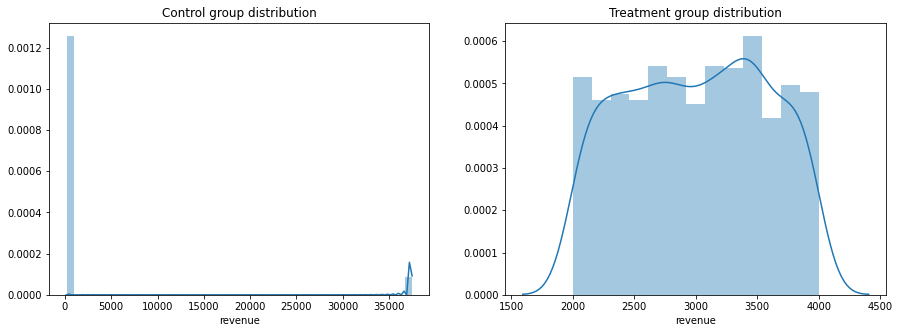

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

#распределние доходов группы A (контрольной)
sns.distplot(data.query('testgroup == "a" & revenue != 0')['revenue'], ax=axes[0])
axes[0].set_title("Control group distribution")

#распределние доходов группы B (тестовой)
sns.distplot(data.query('testgroup == "b" & revenue != 0')['revenue'], ax=axes[1])
axes[1].set_title("Treatment group distribution")

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

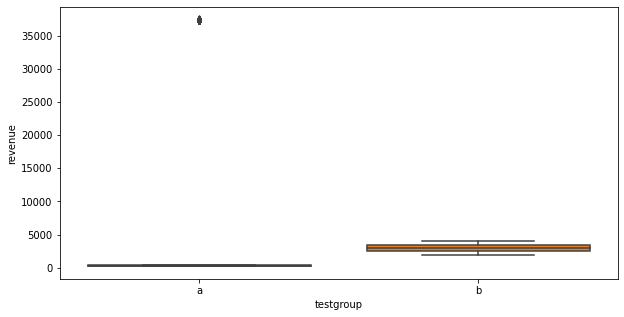

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x='testgroup', y='revenue', data=data.query('revenue != 0'))

В группе А графика boxplot большие значения покупок представлены как выбросы. Но удалить их мы не можем, поскольку такие (большие) значение возникают не единожды и следовательно мы сможем потерять большое количество наблюдений, что сможет сильно изменить результат эксперимента.

In [110]:
#fig_2, axes_2 = plt.subplots(1, 2, figsize=(15, 5), sharey=False)

#sm.qqplot(data.query('testgroup == "a" & revenue != 0')['revenue'], ax=axes_2[0])
#sm.qqplot(data.query('testgroup == "b" & revenue != 0')['revenue'], ax=axes_2[1])
#plt.show()

Глядя на распределения двух выборок можно заметить, что клиенты контрольной группы имеют две крайности: много пользователей тратят мало и в то же время есть те кто тратят очень много, значительно больше чем в тестовой. Что касаемо тестовой группы, то доход распределен практичести равномерно между 2000-4000 у.е.

Проведем оценку нормальности распределений двух групп с помощью теста Шапиро-Уилка.

H0 - выборка распределена нормально

H1 - распределение отличается от нормального

In [14]:
#Проверка распределения выборок на нормальность
a = stats.shapiro(data.query('testgroup == "a" & revenue != 0')['revenue'])
b = stats.shapiro(data.query('testgroup == "b" & revenue != 0')['revenue'])

print("Результат тест Шапиро-Уилка для распрделения контрольной группы: {}".format(a))
print("Результат тест Шапиро-Уилка для распрделения тестовой группы   : {}".format(b))

Результат тест Шапиро-Уилка для распрделения контрольной группы: (0.2667924761772156, 0.0)
Результат тест Шапиро-Уилка для распрделения тестовой группы   : (0.9583123922348022, 2.491345674771425e-22)


Тест Шапиро показал значимый результат для двух групп (p-value < 0.05), следовательно гипотеза о нормальности распределений отвергается.
Это значит, что для сравнения этих выборок мы можем воспользоваться либо непарметрическим методом оценки центральной тенденции, либо методом Bootstrap.

В данном случае нам необходимо оценить метрику ARPU контрольной и тестовой групп. Формула ARPU выглядит как: Revenue/ Users. Чтобы мы смогли верно интерпретировать результаты теста, для оценки среднего дохода будем использовать метод Bootstrap, который за счет того, что многократно считает среднее с возвращением, позволяет сконцентрировать данные выборки вокруг своего истинного среднего c отклонением, несмотря на то, что данные выборок не распределены нормально.
В качестве статистики будет рассчитываться среднее дохода на пользователя, поскольку данная формула (Revenue/n) отражает нашу исследуемую метрику ARPU.

In [17]:
#применим метод Bootstrap
# h0 - ARPU(a) = ARPU(b)
# h1 - ARPU(a) != ARPU(b)
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1 - samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = stats.norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = stats.norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

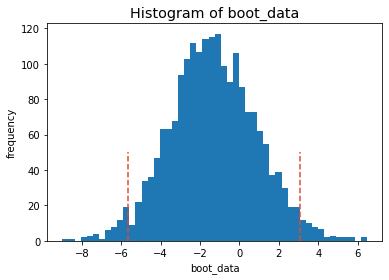

In [18]:
booted_data = get_bootstrap(data.query('testgroup == "a"')['revenue'], data.query('testgroup == "b"')['revenue'], boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [19]:
print("P-value for Bootstrap median: {}".format(booted_data["p_value"])) 
print("Confidence interval: {}".format(booted_data["ci"]))

P-value for Bootstrap median: 0.5477050905656762
Confidence interval:               0
0.025 -5.660437
0.975  3.064052


По результатам теста p-value показал статистически не значимый результат т.к. > 0.05, так же стоит заметить что 0 входит в доверительный интервал, что указыает на отсутсвие оснований отвергнуть нулевую гипотезу о равенстве ARPU.

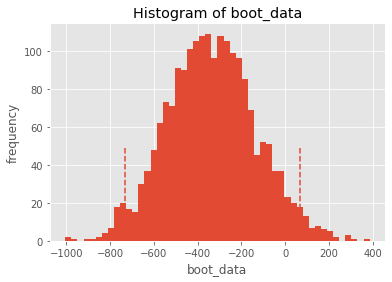

In [22]:
#Проанализируем есть ли статистически значимые различия в  среднем доходе на платящего пользователя (ARPPU) 
#H0: ARPPU(a) = ARPPU(b)
#H1: ARPPU(a) != ARPPU(b)
booted_data_arppu = get_bootstrap(data.query('testgroup == "a" & revenue != 0')['revenue'], data.query('testgroup == "b" & revenue != 0')['revenue'], boot_it = 2000)

In [23]:
print("P-value for Bootstrap median: {}".format(booted_data_arppu["p_value"])) 
print("Confidence interval: {}".format(booted_data_arppu["ci"]))

P-value for Bootstrap median: 0.09782006364485633
Confidence interval:                 0
0.025 -732.854292
0.975   69.380472


По результатам теста p-value показал статистически не значимый результат т.к. > 0.05, так же стоит заметить что 0 входит в доверительный интервал, что указыает на отсутсвие оснований отвергнуть нулевую гипотезу о равенстве ARPPU.

In [24]:
#Непараметрический критерий Крускала-Уоллиса
#H0: median(a) = median(b)
#H1: median(a) != median(b)
#u, p = stats.kruskal(data.query('testgroup == "a"')['revenue'], data.query('testgroup == "b"')['revenue'])
#print("Kruskal-Whallis result: {}".format(p))
                                                                                               

Kruskal-Whallis result: 0.06269700166262313


In [ ]:
#Результат проведенного тест с применением критерия Крускала-Уоллиса показал не значимый результат: p-value > 0.05. Следовательно нулевая гипотеза не отвергается.

##### Вывод: 
Cложно сделать однозначный выбор какой из наборов акций оказался лучше, потому что хоть и в тестовой группе процент пользователей совершивших покупку выше, раница в среднем чеке на пользователя (и на платящего пользователя) статистически значимо не отличается, и прослеживаются значительные отличия в характере платящих пользователей (в тестовой группе присуствует группа клиентов готовых платить значительно больше чем в контрольной, и именно эта часть покупателей невилирует ту разницу, которая возникает можду группами).

В данном случае будет целесообразно проверить корректность работы системы сплитования (возможно она отдает предпочтение одной группе (объединенным по какому то признаку, это могут быть пользователи какой-либо из операционных систем или жители определенных городов или районов) пользователей в тествовой группе, но не показывает акционные предложение такой же группе в контрольной).

Если же при проверке системы сплитования ошибок не обнаружится, то чтобы сделать однозначный выбор стоит отталкиваться от целей компании: можно взять во внимание стастически значимые различия в конверсии в клиента (CR) в тестовой группе, что сигнализирует о том, что в этой группе большее количество пользователей попробовали воспользоваться нашим сервисом и потенциально больше пользователей может вернуться обратно и воспользоваться им еще раз.